In [ ]:
from functools import lru_cache

from langchain_core.messages import SystemMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


@lru_cache(maxsize=None)
def factorial(n: int) -> int:
    if n < 0:
        raise ValueError("Cannot calculate the factorial of a negative number")
    return n * factorial(n - 1) if n else 1


@tool
def calculate_factorial(n: int) -> int:
    """Calculate the factorial of n

    Args:
        n: Value to calculate the factorial of

    Returns:
        int: Result of the factorial calculation
    """
    return factorial(n)


@tool
def multiply(a: int, b: int) -> int:
    """Multiply the input a b y b

    Args:
        a: First number to multiply
        b: Second number to multiply

    Returns:
        int: Result of the multiplication
    """
    return a * b

In [ ]:
tools = [calculate_factorial, multiply]

In [ ]:
model = ChatOpenAI(model="mistralai/mistral-small-3.2-24b-instruct")
model_with_tools = model.bind_tools(tools)

In [ ]:
def math_llm(state):
    system_message = SystemMessage(
        content="You are a helpful math assistant that explains what it does."
    )

    full_messages = [system_message] + state["messages"]

    response = model_with_tools.invoke(full_messages)

    return {"messages": state["messages"] + [response]}

In [ ]:
graph = StateGraph(MessagesState)
# Add nodes
graph.add_node("math_llm", math_llm)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("math_llm")
graph.add_edge("tools", "math_llm")
graph.add_conditional_edges("math_llm", tools_condition)

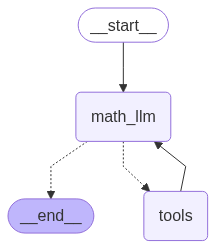

In [ ]:
agent = graph.compile()
agent

In [ ]:
response = agent.invoke(
    {"messages": "Calculate the factorial of 5 and mutliply it by 21"}
)

In [ ]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Calculate the factorial of 5 and mutliply it by 21
================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (8k6ghTNz5)
 Call ID: 8k6ghTNz5
  Args:
    n: 5
  multiply (IsnFpVq2I)
 Call ID: IsnFpVq2I
  Args:
    a: 120
    b: 21
================================= Tool Message =================================
Name: calculate_factorial

120
================================= Tool Message =================================
Name: multiply

2520
================================== Ai Message ==================================

The factorial of 5 is 120 and 120 multiplied by 21 is 2520.


# HITL

In [ ]:
def route_feedback(state):
    """Route based on the last message in the conversation"""
    last_message = state["messages"][-1]
    print(f"Last message type: {last_message.type}")

    if last_message.type == "ai":
        if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0:
            print(
                f"AI message has {len(last_message.tool_calls)} tool calls - routing to tools"
            )
            return "tools"
        else:
            print("AI message has no tool calls - ending")
            return END
    else:
        print("Non-AI message - routing to math_llm")
        return "math_llm"


# Define the nodes
graph = StateGraph(MessagesState)
graph.add_node("math_llm", math_llm)
graph.add_node(
    "feedback", lambda state: {"messages": state["messages"]}
)  # Pass through state
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "math_llm")
graph.add_edge("math_llm", "feedback")
graph.add_conditional_edges(
    "feedback", route_feedback, {"tools": "tools", END: END, "math_llm": "math_llm"}
)
graph.add_edge(
    "tools", "feedback"
)  # After tools execute, go back to feedback for routing

memory = MemorySaver()

agent = graph.compile(interrupt_before=["feedback"], checkpointer=memory)

# Let's also inspect the graph structure
print("Graph nodes:", list(graph.nodes.keys()))
print("Graph edges:", list(graph.edges))

Graph nodes: ['math_llm', 'feedback', 'tools']
Graph edges: [('__start__', 'math_llm'), ('tools', 'feedback'), ('math_llm', 'feedback')]


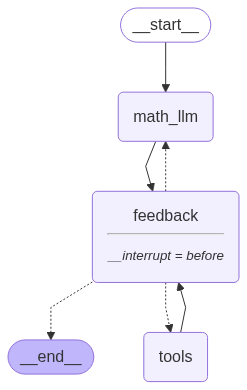

In [ ]:
agent

In [ ]:
initial_input = {"messages": "Get the result of 5 factorial and multiply it by 5."}

thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in agent.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Get the result of 5 factorial and multiply it by 5.
================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ALFWEqbkN)
 Call ID: ALFWEqbkN
  Args:
    n: 5
  multiply (ksyrwPa0R)
 Call ID: ksyrwPa0R
  Args:
    a: 120
    b: 5


In [ ]:
for event in agent.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ALFWEqbkN)
 Call ID: ALFWEqbkN
  Args:
    n: 5
  multiply (ksyrwPa0R)
 Call ID: ksyrwPa0R
  Args:
    a: 120
    b: 5
Last message type: ai
AI message has 2 tool calls - routing to tools
================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ALFWEqbkN)
 Call ID: ALFWEqbkN
  Args:
    n: 5
  multiply (ksyrwPa0R)
 Call ID: ksyrwPa0R
  Args:
    a: 120
    b: 5
================================= Tool Message =================================
Name: multiply

600


In [ ]:
fresh_thread = {"configurable": {"thread_id": "2"}}

for event in agent.stream(
    {"messages": "Calculate the result of 3 factorial and multiply by 5"},
    fresh_thread,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Calculate the result of 3 factorial and multiply by 5
================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ghHx5HFoT)
 Call ID: ghHx5HFoT
  Args:
    n: 3
  multiply (6sFf9dPTX)
 Call ID: 6sFf9dPTX
  Args:
    a: 6
    b: 5


In [ ]:
for event in agent.stream(None, fresh_thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ghHx5HFoT)
 Call ID: ghHx5HFoT
  Args:
    n: 3
  multiply (6sFf9dPTX)
 Call ID: 6sFf9dPTX
  Args:
    a: 6
    b: 5
Last message type: ai
AI message has 2 tool calls - routing to tools
================================== Ai Message ==================================
Tool Calls:
  calculate_factorial (ghHx5HFoT)
 Call ID: ghHx5HFoT
  Args:
    n: 3
  multiply (6sFf9dPTX)
 Call ID: 6sFf9dPTX
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: multiply

30
